In [165]:
import numpy as np
import matplotlib.pyplot as plt
import astra
from skimage.transform import radon, rescale, rotate
from scipy.interpolate import RectBivariateSpline
from collections import namedtuple
from matplotlib.animation import FuncAnimation

astra.test()

ASTRA Toolbox v2.2.0
Getting GPU info... GPU #0: NVIDIA GeForce RTX 2070 SUPER, with 8191MB, CUDA compute capability 7.5
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


## Define 3D volume

In [166]:
volume_size = np.array((64, 64, 64), dtype=np.int32)
voxel_grid = np.zeros(volume_size, dtype=np.float64)

# Add a spherical shape to the voxel grid for simplicity
x, y, z = np.meshgrid(
    np.linspace(-1, 1 , volume_size[0]),
    np.linspace(-1, 1 , volume_size[1]),
    np.linspace(-1, 1 , volume_size[2]),
)

Sphere = namedtuple('Sphere', ['radius', 'center', 'weight'])
spheres = [
    Sphere(0.8,     (0.0, 0.0, 0.0),        1.0 ),
    Sphere(0.30,    (0.1, 0.1, 0.1),        0.5 ),
    Sphere(0.30,    (-0.20, -0.2, 0.0),      -1.0),
]
for sphere in spheres:
    distance = np.sqrt((x - sphere.center[0])**2 + (y - sphere.center[1])**2 + (z - sphere.center[2])**2)
    # where distance < sphere.radius add weight to the voxel grid
    voxel_grid += np.where(distance < sphere.radius, sphere.weight, 0.0)

Cuboid = namedtuple('Cuboid', ['length', 'width', 'height', 'top_left', 'weight'])
cuboids = [
    Cuboid(0.5, 0.8, 0.3, (-0.8, -0.5, 0.6), 1.0),
]
for cuboid in cuboids:
    x_min = cuboid.top_left[0]
    x_max = cuboid.top_left[0] + cuboid.length
    y_min = cuboid.top_left[1]
    y_max = cuboid.top_left[1] + cuboid.width
    z_min = cuboid.top_left[2]
    z_max = cuboid.top_left[2] + cuboid.height
    voxel_grid += np.where(
        (x >= x_min) & (x <= x_max) &
        (y >= y_min) & (y <= y_max) &
        (z >= z_min) & (z <= z_max),
        cuboid.weight, 0.0
    )

# Normalize array to [0, 1]
min_voxel = voxel_grid.min()
max_voxel = voxel_grid.max()
voxel_grid = (voxel_grid - min_voxel) / (max_voxel - min_voxel)

In [167]:
def plot_voxel_grid(voxels):
    """ Plots a 3D volume normalized to [0, 1] """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x_indices, y_indices, z_indices = np.indices(voxels.shape)
    ax.scatter(
        x_indices.flatten(), y_indices.flatten(), z_indices.flatten(),
        c=voxels.flatten(),
        cmap='viridis',
        s=0.002,
        marker='x'
    )
    fig.colorbar(ax.collections[0], ax=ax, orientation='vertical')
    plt.show()

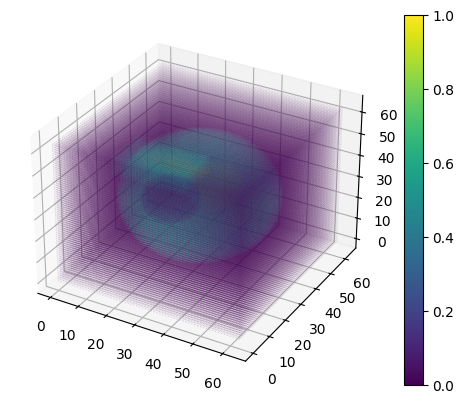

In [168]:
plot_voxel_grid(voxel_grid)

## Simulate Parallel Beam CT  
We will be simulating a 2D matrix detector parallel-beam CT scan for 3D re-construction. 

Each ray is parallel, we rotate through the angels $\Theta=[\theta_0 \ldots \theta_{n-1}]$ 

<br>

Note there do exists other more efficient but more complex methods 
- In Cone Beam CT we get a slice a per rotation as it takes a 2D slice scan per rotation. 



In [169]:
vol_geom = astra.create_vol_geom(
    int(volume_size[0]), 
    int(volume_size[1]), 
    int(volume_size[2]),
)
angles = np.linspace(-np.pi, np.pi, 180)

# For now we let the detector resolution be same as the volume size
detector_resolution = np.array([volume_size[0], volume_size[1]])
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, detector_resolution[0], detector_resolution[1], angles)

## Forward Projection (sinogram)

In [170]:
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, detector_resolution[0], detector_resolution[1], angles)

volume_id = astra.data3d.create('-vol', vol_geom, voxel_grid)
proj_id = astra.create_projector('cuda3d', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino3d_gpu(volume_id, proj_geom, vol_geom, returnData=True)


In [171]:
def create_gif(sinogram, angles, output_filename='2d_sinogram.gif', fps=10):
    sinogram = np.moveaxis(sinogram, 0, 1)
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(sinogram[0], cmap='viridis')
    plt.colorbar(img, label='Intensity')
    
    def update(frame):
        """Update function for animation"""
        # Clear the current plot
        ax.clear()
        
        # Create new image
        img = ax.imshow(sinogram[frame], cmap='viridis')
        ax.set_title(f'Sinogram Slice (Angle: {angles[frame]/np.pi * 180:.1f}°)')
        
        return [img]
    anim = FuncAnimation(
        fig, 
        update,
        frames=len(angles),
        interval=1000/fps,  # interval in milliseconds
        blit=True
    )
    anim.save(
        output_filename,
        writer='pillow',
        fps=fps
    )
    plt.close()

create_gif(sinogram, angles)

We can visualize what the scanner head see (as the angle of the scanner changes). 

<div>
<img src="./2d_sinogram.gif" width="500"/>
</div>

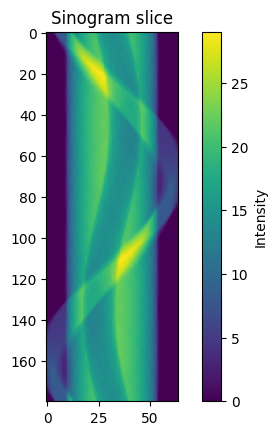

(64, 180, 64)

In [172]:
# Visualize one slice of the sinogram
# (64,180,64) -> (180,64,64)
idx = sinogram.shape[0] // 7 + 11
plt.imshow(sinogram[idx], cmap='viridis')
plt.title("Sinogram slice")
plt.colorbar(label='Intensity')
plt.show()

sinogram.shape

In [173]:
astra.data3d.delete(volume_id)
astra.data3d.delete(sinogram_id)
astra.projector.delete(proj_id)

## Backprojection (Reconstruction)

Write a function to get ASTRA to backproject the sinogram to 3D volume using the SIRT Algorithm (an algebraic topographical reconstruction technique)

In [174]:
def reconstruct_3d_volume_alg(sinogram, proj_geom, vol_geom, num_iterations=4):
    sinogram_id = astra.data3d.create('-proj3d', proj_geom, sinogram)
    reconstruction_id = astra.data3d.create('-vol', vol_geom)
    
    # Initialize algorithm parameters
    alg_cfg = astra.astra_dict('SIRT3D_CUDA')
    alg_cfg['ProjectionDataId'] = sinogram_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)

    astra.algorithm.run(algorithm_id, num_iterations)
    reconstruction = astra.data3d.get(reconstruction_id)
    
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(sinogram_id)
    astra.data3d.delete(reconstruction_id)
    
    return reconstruction

Here is another reconstruction method using BP3D (Filted Backprojection) 

In [180]:
def ramp_filter(projections):
    filtered = np.zeros_like(projections)
    nangles, height, width = projections.shape
    
    # Create ramp filter
    freq = np.fft.fftfreq(width)
    ramp = np.abs(freq)
    
    # Apply filter to each projection
    for angle in range(nangles):
        for row in range(height):
            proj = projections[angle, row]
            proj_fft = np.fft.fft(proj)
            filtered[angle, row] = np.real(np.fft.ifft(proj_fft * ramp))
    
    return filtered

def reconstruct_3d_volume_fbp(sinogram, proj_geom, vol_geom):
    filtered_sinogram = ramp_filter(sinogram)
    sinogram_id = astra.data3d.create('-proj3d', proj_geom, filtered_sinogram)
    reconstruction_id = astra.data3d.create('-vol', vol_geom)
    
    # Set up the backprojection
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = sinogram_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)
    
    # Scale the reconstruction
    # The scaling factor depends on the number of projections and geometry
    reconstruction *= (np.pi / (2 * sinogram.shape[0]))
    
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(sinogram_id)
    astra.data3d.delete(reconstruction_id)
    
    return reconstruction

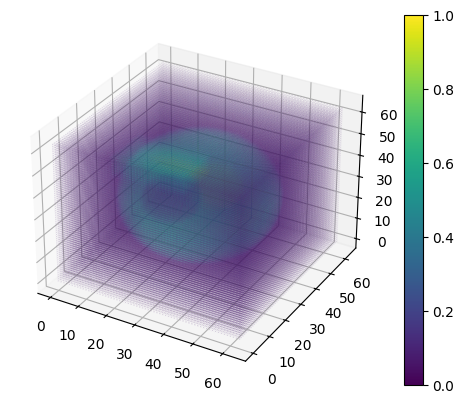

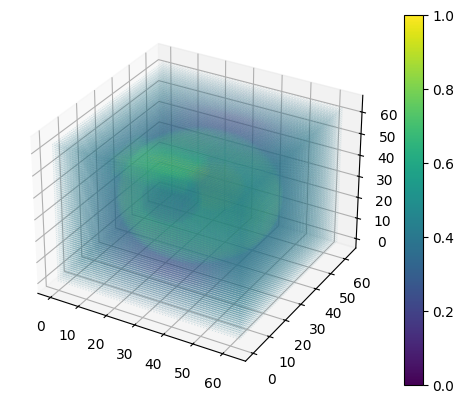

In [195]:
recon_alg = reconstruct_3d_volume_alg(sinogram, proj_geom, vol_geom, 55)
recon_fbp = reconstruct_3d_volume_fbp(sinogram, proj_geom, vol_geom)

# Normalize array to [0, 1]
recon_alg = (recon_alg - recon_alg.min()) / (recon_alg.max() - recon_alg.min())
recon_fbp = (recon_fbp - recon_fbp.min()) / (recon_fbp.max() - recon_fbp.min())

plot_voxel_grid(recon_alg)
plot_voxel_grid(recon_fbp)

In [196]:
def visualize_reconstruction(original, reconstructed, slice_idx=None):
    if slice_idx is None:
        slice_idx = original.shape[0] // 2
    
    # Calculate the difference
    difference = original[slice_idx] - reconstructed[slice_idx]

    # Create subplots with adjusted size
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))  

    # Plot original slice
    im1 = ax1.imshow(original[slice_idx], cmap='viridis')
    ax1.set_title(f'Original Volume (Slice {slice_idx})')
    plt.colorbar(im1, ax=ax1, shrink=0.4)

    # Plot reconstructed slice
    im2 = ax2.imshow(reconstructed[slice_idx], cmap='viridis')
    ax2.set_title(f'Reconstructed Volume (Slice {slice_idx})')
    plt.colorbar(im2, ax=ax2, shrink=0.4)

    # Plot difference slice
    im3 = ax3.imshow(difference, cmap='viridis')
    ax3.set_title(f'Difference (Slice {slice_idx})')
    plt.colorbar(im3, ax=ax3, shrink=0.4)

    plt.tight_layout()
    plt.show()

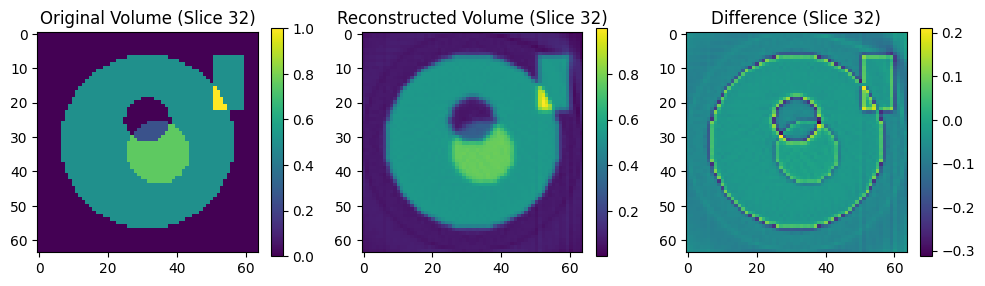

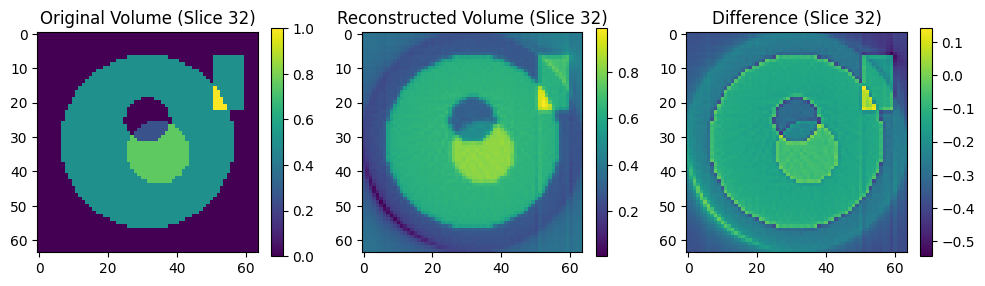

Mean Squared Error (SIRT): 0.00536
Mean Squared Error (FBP): 0.10766


In [197]:
visualize_reconstruction(voxel_grid, recon_alg)
visualize_reconstruction(voxel_grid, recon_fbp)

error = np.mean((voxel_grid - recon_alg) ** 2)
print(f"Mean Squared Error (SIRT): {error:.5f}")
error = np.mean((voxel_grid - recon_fbp) ** 2)
print(f"Mean Squared Error (FBP): {error:.5f}")

In [200]:
def create_gif(recon, output_filename, fps=10):
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(recon[0], cmap='viridis')
    plt.colorbar(img, label='Intensity')
    
    def update(frame):
        ax.clear()
        img = ax.imshow(recon[frame], cmap='viridis')
        ax.set_title(f'Back Projection Slice ({frame})')
        
        return [img]
    anim = FuncAnimation(
        fig, 
        update,
        frames=recon.shape[0],
        interval=1000/fps,  # interval in milliseconds
        blit=True
    )
    anim.save(
        output_filename,
        writer='pillow',
        fps=fps
    )
    plt.close()

create_gif(recon_alg, "ct_scan_alg.gif")
create_gif(recon_fbp, "ct_scan_fbp.gif")

On the left is the algebraic reconstruction and on the right is the filtered back projection. 
<div style="display: flex; align-items: center;">
    <img src="./ct_scan_alg.gif" width="300"/>
    <img src="./ct_scan_fbp.gif" width="300"/>
</div>